In [ ]:
import torch
import numpy as np
from transformer_lens import HookedTransformer

device = "cpu"
print(f"Active Device: {device}")

In [ ]:
model = HookedTransformer.from_pretrained(
    "gemma-2-2b",
    device=device,
)

# Preparing Prompts

In [ ]:
# Sorted by longitude
states_prompts = [
    'Hawaii', 'Alaska', 'Washington', 'Oregon', 'California', 'Nevada', 'Idaho', 'Arizona', 'Utah', 'Montana', 'Wyoming',
    'New Mexico', 'Colorado', 'North Dakota', 'South Dakota', 'Nebraska', 'Texas', 'Kansas', 'Oklahoma', 'Minnesota',
    'Iowa', 'Missouri', 'Arkansas', 'Louisiana', 'Mississippi', 'Wisconsin', 'Illinois', 'Alabama', 'Tennessee', 'Indiana',
    'Michigan', 'Kentucky', 'Georgia', 'Ohio', 'Florida', 'South Carolina', 'West Virginia', 'North Carolina', 'Virginia',
    'Pennsylvania', 'Maryland', 'Delaware', 'New York', 'New Jersey', 'Connecticut', 'Vermont', 'Massachusetts', 'New Hampshire',
    'Rhode Island', 'Maine'
]


states_contextualized_prompts = [f"The location of the US state {st}" for st in states_prompts]

months_prompts = ["January", "February","March","April","May","June","July","August","September","October","November","December"]
months_contextualized_prompts = [f"The month of the year is {s}" for s in months_prompts]

years_prompts = [str(i) for i in range(1700, 2022)]
years_contextualized_prompts = [f"In the year {s}" for s in years_prompts]

# Processing Data

In [ ]:
def get_activation_vectors_per_layer(prompts,layers_to_check = list(range(26))):
    hook_template = "blocks.{layer}.hook_resid_post"
    result = {}

    for layer in layers_to_check:
        hook_name = hook_template.format(layer=layer)
        raw_vectors = []

        with torch.no_grad():
            for s in prompts:
                _, cache = model.run_with_cache(s, names_filter=[hook_name])

                # Extract vector from last token
                raw_act = cache[hook_name][0, -1, :]
                raw_vectors.append(raw_act.detach().cpu().numpy())

        raw_map = dict(zip(prompts, raw_vectors))
        result[f"layer_{layer}"] = raw_map

    return result

In [ ]:
result_months = get_activation_vectors_per_layer(months_prompts)
result_months_contextualized = get_activation_vectors_per_layer(months_contextualized_prompts)

result_years = get_activation_vectors_per_layer(years_prompts)
result_years_contextualized = get_activation_vectors_per_layer(years_contextualized_prompts)

result_states = get_activation_vectors_per_layer(states_prompts)
result_states_contextualized = get_activation_vectors_per_layer(states_contextualized_prompts)

# Saving data

In [ ]:
np.save("months_reps_by_layer.npy", np.array(result_months, dtype=object), allow_pickle=True)
np.save("months_contextualized_reps_by_layer.npy", np.array(result_months_contextualized, dtype=object), allow_pickle=True)

np.save("years_reps_by_layer.npy", np.array(result_years, dtype=object), allow_pickle=True)
np.save("years_contextualized_reps_by_layer.npy", np.array(result_years_contextualized, dtype=object), allow_pickle=True)

np.save("states_reps_by_layer.npy", np.array(result_states, dtype=object), allow_pickle=True)
np.save("states_contextualized_reps_by_layer.npy", np.array(result_states_contextualized, dtype=object), allow_pickle=True)

## Plotting context fixing

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import re

In [ ]:
raw_by_layer_contextualized = np.load("months_contextualized_reps_by_layer.npy", allow_pickle=True).tolist()
raw_by_layer = np.load("months_reps_by_layer.npy", allow_pickle=True).tolist()

In [2]:
plt.rcParams.update({
        "font.family": "serif",
        "font.serif": "Times New Roman",
        "mathtext.fontset": "stix",
    })

/var/folders/h1/36rwj0ms6fg7n8yjfzwrcl3w0000gn/T/ipykernel_18937/450182613.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  month_colors = cm.get_cmap("hsv")(1 - np.arange(12)/12.0)   # (12,4)


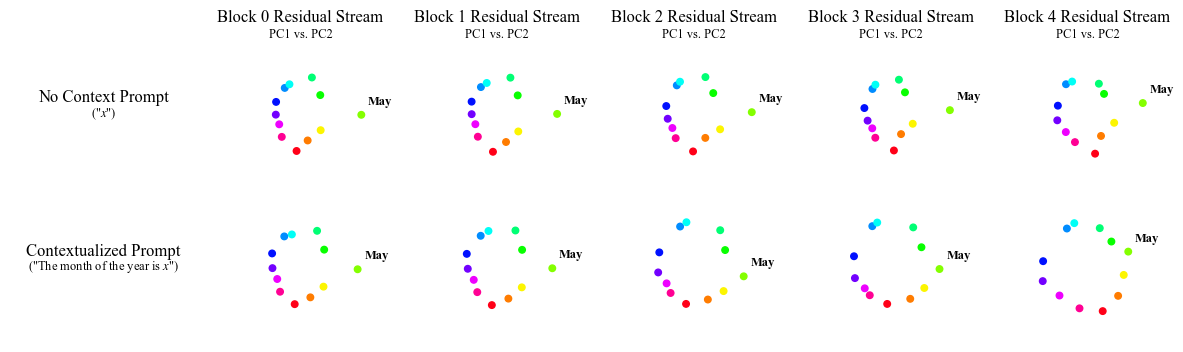

In [ ]:
MONTH_NAMES = ["january","february","march","april","may","june",
               "july","august","september","october","november","december"]
MONTH_ABBR  = ["Jan","Feb","Mar","Apr","May","Jun",
               "Jul","Aug","Sep","Oct","Nov","Dec"]

month_colors = cm.get_cmap("hsv")(1 - np.arange(12)/12.0)   # (12,4)
month_colors = np.roll(month_colors, 7, axis=0)             # (12,4)


def _month_idx(key: str) -> int:
    k = str(key).lower()
    if k in MONTH_NAMES:
        return MONTH_NAMES.index(k)
    for i, m in enumerate(MONTH_NAMES):
        if m in k:
            return i
    for i, a in enumerate(MONTH_ABBR):
        if a.lower() in k:
            return i
    raise ValueError(f"Could not infer month from key: {key!r}")

def _month_matrix(d: dict) -> np.ndarray:
    picked = {}
    for k, v in d.items():
        mi = _month_idx(k)
        if mi not in picked:
            picked[mi] = np.asarray(v)
    if len(picked) != 12:
        raise ValueError(f"Expected 12 unique months, got {len(picked)}")
    return np.stack([picked[i] for i in range(12)], axis=0)

def _kpca2(X: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    X = np.asarray(X, dtype=np.float64)
    n = X.shape[0]
    K = X @ X.T
    H = np.eye(n) - np.ones((n, n)) / n
    Kc = H @ K @ H
    w, V = np.linalg.eigh(Kc)
    w = np.maximum(w, 0.0)
    idx = np.argsort(w)[::-1]
    w, V = w[idx], V[:, idx]
    w2 = np.maximum(w[:2], eps)
    return V[:, :2] * np.sqrt(w2)[None, :]

def _apply_sign_rules(Z: np.ndarray, may_idx: int = 4, blue_threshold: int = 5) -> np.ndarray:
    Z = np.asarray(Z, dtype=np.float64).copy()
    if int(np.argmax(Z[:, 1])) > blue_threshold:
        Z[:, 1] *= -1.0
    if Z[may_idx, 0] < 0:
        Z[:, 0] *= -1.0
    return Z

def _layer_title(layer_key: str) -> str:
    m = re.fullmatch(r"layer_(\d+)", str(layer_key))
    return f"Block {int(m.group(1))} Residual Stream" if m else f"{layer_key} Residual Stream"

def plot_month_kpca_grid(fig, raw_by_layer, raw_by_layer_ctx, layers, sizes):
    row_titles     = ["No Context Prompt", "Contextualized Prompt"]
    row_subtitles  = [r'("$x$")', r'("The month of the year is $x$")']
    col_subtitle   = "PC1 vs. PC2"

    point_size = 22
    aspect = 1.1

    main_fs = 12
    sub_fs  = 9
    label_main_y, label_sub_y = 0.60, 0.50
    col_main_y, col_sub_y     = 1.08, 0.98

    left, right, top, bottom = 0.02, 0.98, 0.95, 0.00
    wspace, hspace = 0.05, 0.02

    # we label May
    may_idx = MONTH_NAMES.index("may")

    ncols = len(layers)
    nrows = 2

    gs = fig.add_gridspec(
        nrows=nrows, ncols=1 + ncols,
        width_ratios=[1] + [1]*ncols,
        left=left, right=right, top=top, bottom=bottom,
        wspace=wspace, hspace=hspace
    )

    label_axes = [fig.add_subplot(gs[i, 0]) for i in range(nrows)]
    axes = np.array([[fig.add_subplot(gs[i, j+1]) for j in range(ncols)] for i in range(nrows)], dtype=object)

    for i, ax in enumerate(label_axes):
        ax.text(0.5, label_main_y, row_titles[i], ha="center", va="center", fontsize=main_fs)
        ax.text(0.5, label_sub_y,  row_subtitles[i], ha="center", va="center", fontsize=sub_fs)
        ax.set_axis_off()

    # precompute KPCA per layer for both rows
    Z_no, Z_ctx = [], []
    for L in layers:
        Z0 = _apply_sign_rules(_kpca2(_month_matrix(raw_by_layer[L])), may_idx=may_idx)
        Z1 = _apply_sign_rules(_kpca2(_month_matrix(raw_by_layer_ctx[L])), may_idx=may_idx)
        Z_no.append(Z0); Z_ctx.append(Z1)

    for i in range(nrows):
        for j in range(ncols):
            ax = axes[i, j]
            Z = Z_no[j] if i == 0 else Z_ctx[j]

            ax.scatter(Z[:, 0], Z[:, 1], c=month_colors, s=point_size)

            xm, ym = Z[may_idx, 0], Z[may_idx, 1]
            ax.annotate("May", xy=(xm, ym),
                        xytext=(5.0, 5.0), textcoords="offset points",
                        fontsize=9, fontweight="bold", ha="left", va="bottom")

            if i == 0:
                ax.text(0.5, col_main_y, _layer_title(layers[j]),
                        transform=ax.transAxes, ha="center", va="bottom",
                        fontsize=main_fs, clip_on=False)
                ax.text(0.5, col_sub_y, col_subtitle,
                        transform=ax.transAxes, ha="center", va="bottom",
                        fontsize=sub_fs, clip_on=False)

            ax.set_aspect(aspect, adjustable="box")
            ax.set_axis_off()

            span = max(Z[:, 0].max() - Z[:, 0].min(),
                       Z[:, 1].max() - Z[:, 1].min())
            extent = sizes[j] * float(span) if np.isfinite(span) and span > 0 else 1.0
            ax.set_xlim(-extent, extent)
            ax.set_ylim(-extent, extent)

    return fig


layers = ["layer_0", "layer_1", "layer_2", "layer_3", "layer_4"]
fig = plt.figure(figsize=(2.2 * len(layers) + 1.2, 3.2))
plot_month_kpca_grid(fig, raw_by_layer, raw_by_layer_contextualized, layers=layers, sizes=[0.80]*len(layers))
plt.show()

In [ ]:
out_path = "months_kpca_grid.pdf"

fig.savefig(out_path, format="pdf", bbox_inches="tight", pad_inches=0.02)
print("Saved:", out_path)
